## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
from pprint import pprint


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn import ensemble
from sklearn.metrics import plot_confusion_matrix
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



## Carregando dataset

In [2]:
dataset = pd.read_csv("https://raw.githubusercontent.com/RHero-UFRPE/RHero-ML/master/WA_Fn-UseC_-HR-Employee-Attrition.csv")
dataset.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


## Pré processamento de dados 

## Transformação das variáveis categóricas nominais

- Variável *Attrition*

In [3]:
attrition_map = {'Yes' : 1, 'No' : 0}
dataset['Attrition'] = dataset['Attrition'].map(attrition_map)
dataset.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


- Demais variáveis categóricas nominais

In [4]:
numerical = ['Age', 'DailyRate', 'DistanceFromHome', 
             'Education', 'EmployeeNumber', 'EnvironmentSatisfaction',
             'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction',
             'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
             'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
             'StockOptionLevel', 'TotalWorkingYears',
             'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
             'YearsInCurrentRole', 'YearsSinceLastPromotion','YearsWithCurrManager']
categorical = []
for col, value in dataset.iteritems():
    if value.dtype == 'object':
        categorical.append(col)
numerical = dataset.columns.difference(categorical)
attrition_num = dataset[numerical]

In [5]:
attrition_categorico = dataset[categorical]
attrition_categorico = pd.get_dummies(attrition_categorico)
attrition_categorico.head(3)

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1
1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0
2,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1


In [6]:
dataset = pd.concat([attrition_num, attrition_categorico], axis=1)
dataset.head(3)

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
0,41,1,1102,1,2,1,1,2,94,3,2,4,5993,19479,8,11,3,1,80,0,8,0,1,6,4,0,5,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1
1,49,0,279,8,1,1,2,3,61,2,2,2,5130,24907,1,23,4,4,80,1,10,3,3,10,7,1,7,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0
2,37,1,1373,2,2,1,4,4,92,2,1,3,2090,2396,6,15,3,2,80,0,7,3,3,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1


In [7]:
dataset.shape

(1470, 56)

## Mudando o índice do Attrition para facilitar o slicing entre atributos e target 

In [8]:
dataset = dataset.reindex(columns=(['Attrition'] + list([a for a in dataset.columns if a != 'Attrition']) ))
dataset.head()

,Attrition,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
0,1,41,1102,1,2,1,1,2,94,3,2,4,5993,19479,8,11,3,1,80,0,8,0,1,6,4,0,5,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1
1,0,49,279,8,1,1,2,3,61,2,2,2,5130,24907,1,23,4,4,80,1,10,3,3,10,7,1,7,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0
2,1,37,1373,2,2,1,4,4,92,2,1,3,2090,2396,6,15,3,2,80,0,7,3,3,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1
3,0,33,1392,3,4,1,5,4,56,3,1,3,2909,23159,1,11,3,3,80,0,8,3,3,8,7,3,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1
4,0,27,591,2,1,1,7,1,40,3,1,2,3468,16632,9,12,3,4,80,1,6,3,3,2,2,2,2,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0


## Realizando o drop de atributos com valor único nos registros 

In [9]:
atributos = dataset.iloc[:,1:]
target = dataset['Attrition']
print("Shape original (atributos): ", atributos.shape)
atributos.drop(['Over18_Y', 'EmployeeCount', 'StandardHours'], axis=1, inplace=True)
print("Shape pós remoção (atributos): ", atributos.shape)


Shape original (atributos):  (1470, 55)
Shape pós remoção (atributos):  (1470, 52)


In [10]:
#Dividindo o dataset em variáveis para o teste e para o treino
atributos_train, atributos_test, target_train, target_test = train_test_split(atributos, target, random_state=42)

In [11]:
# Frequência da divisão do dataset em parte de treino e de teste 
print("{0:0.2f}% nos dados de treino". format((len(atributos_train)/len(atributos.index)) * 100 ))
print("{0:0.2f}% nos dados de teste". format((len(atributos_test)/len(atributos.index)) * 100 ))

74.97% nos dados de treino
25.03% nos dados de teste


In [12]:
#Frequência do atributo Attrition na base de treino
target_train.value_counts()

0    913
1    189
Name: Attrition, dtype: int64

In [13]:
#Frequência do atributo Attrition na base de treino
target_test.value_counts()

0    320
1     48
Name: Attrition, dtype: int64

## Reamostragem: Oversampling

In [14]:
oversample_atributos_train, oversample_atributos_test, oversample_target_train, oversample_target_test = train_test_split(atributos, target, random_state=42)
oversample_datasetTrain = pd.concat([oversample_atributos_train, oversample_target_train], axis=1)


In [15]:
not_attrition = oversample_datasetTrain[oversample_datasetTrain.Attrition==0]
yes_attrition = oversample_datasetTrain[oversample_datasetTrain.Attrition==1]

#upsample minority

attrition_upsampled = resample(yes_attrition,replace=True,n_samples=len(not_attrition), random_state=27)
upsampled = pd.concat([not_attrition, attrition_upsampled])
upsampled_target_train = upsampled.Attrition
upsampled_atributte_train = upsampled.drop('Attrition', axis=1)

upsampled.Attrition.value_counts()

1    913
0    913
Name: Attrition, dtype: int64

### Aplicação de Modelos com Oversampling

- *Random Forest*

In [16]:
oversample_model_RF  = RandomForestClassifier(random_state= 42)
oversample_model_RF.fit(upsampled_atributte_train, upsampled_target_train.ravel())
predict_RF_oversample = oversample_model_RF.predict(oversample_atributos_test)

In [17]:
print("Acurácia do modelo: {0:.2f}%".format(metrics.accuracy_score(oversample_target_test, predict_RF_oversample) * 100))
print()

print("Confusion Matrix")
print("")

print("{0}".format(metrics.confusion_matrix(oversample_target_test, predict_RF_oversample, labels = [1,0])))
print(" ")

print("Classification Report")
print("")

print(metrics.classification_report(oversample_target_test, predict_RF_oversample, labels = [1,0]))

Acurácia do modelo: 88.04%

Confusion Matrix

[[ 11  37]
 [  7 313]]
 
Classification Report

              precision    recall  f1-score   support

           1       0.61      0.23      0.33        48
           0       0.89      0.98      0.93       320

    accuracy                           0.88       368
   macro avg       0.75      0.60      0.63       368
weighted avg       0.86      0.88      0.86       368



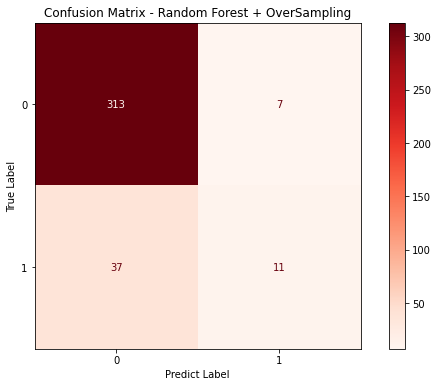

In [18]:
matrix_RF = plot_confusion_matrix(oversample_model_RF , oversample_atributos_test, oversample_target_test, cmap=plt.cm.Reds, values_format = '.5g')
matrix_RF.ax_.set_title('Confusion Matrix - Random Forest + OverSampling', color = 'black')
plt.xlabel('Predict Label', color='black')
plt.ylabel('True Label', color='black')
plt.gcf().axes[1].tick_params(colors='black')
plt.gcf().axes[0].tick_params(colors='black')
plt.gcf().set_size_inches(10,6)
plt.show()

- *Gradient Boosting*

In [19]:
oversample_model_GB = ensemble.GradientBoostingClassifier(random_state=42, n_estimators=100)
oversample_model_GB.fit(upsampled_atributte_train, upsampled_target_train.ravel())
oversample_predict_GB = oversample_model_GB.predict(oversample_atributos_test)


In [20]:
#Confusion Matrix e Classification Report

print("Acurácia do modelo: {0:.2f}%".format(metrics.accuracy_score(oversample_target_test, oversample_predict_GB) * 100))
print()

print("Confusion Matrix")
print("")

print("{0}".format(metrics.confusion_matrix(oversample_target_test, oversample_predict_GB, labels = [1,0])))
print(" ")

print("Classification Report")
print("")

print(metrics.classification_report(oversample_target_test, oversample_predict_GB, labels = [1,0]))





Acurácia do modelo: 83.15%

Confusion Matrix

[[ 23  25]
 [ 37 283]]
 
Classification Report

              precision    recall  f1-score   support

           1       0.38      0.48      0.43        48
           0       0.92      0.88      0.90       320

    accuracy                           0.83       368
   macro avg       0.65      0.68      0.66       368
weighted avg       0.85      0.83      0.84       368



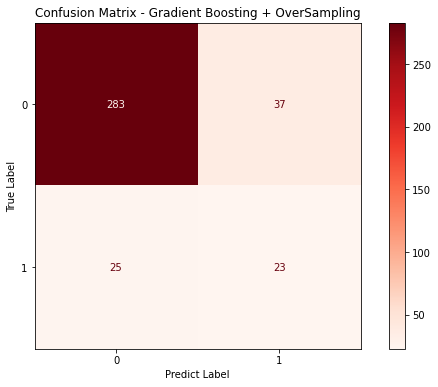

In [21]:
matrix_RF = plot_confusion_matrix(oversample_model_GB , oversample_atributos_test, oversample_target_test, cmap=plt.cm.Reds, values_format = '.5g')
matrix_RF.ax_.set_title('Confusion Matrix - Gradient Boosting + OverSampling', color = 'black')
plt.xlabel('Predict Label', color='black')
plt.ylabel('True Label', color='black')
plt.gcf().axes[1].tick_params(colors='black')
plt.gcf().axes[0].tick_params(colors='black')
plt.gcf().set_size_inches(10,6)
plt.show()

## Reamostragem: Undersampling

In [22]:
undersample_atributos_train, undersample_atributos_test, undersample_target_train, undersample_target_test = train_test_split(atributos, target, random_state=42)
undersample_datasetTrain = pd.concat([undersample_atributos_train, undersample_target_train], axis=1)


In [23]:
not_attrition_under = undersample_datasetTrain[undersample_datasetTrain.Attrition==0]
yes_attrition_under = undersample_datasetTrain[undersample_datasetTrain.Attrition==1]

#downsample majority
not_attrition_downsampled = resample(not_attrition_under,replace = False, n_samples = len(yes_attrition_under),  random_state = 27) 
downsampled = pd.concat([not_attrition_downsampled, yes_attrition_under])
downsampled_train_target = downsampled.Attrition
downsampled_train_attribute = downsampled.drop('Attrition', axis=1)

downsampled.Attrition.value_counts()


1    189
0    189
Name: Attrition, dtype: int64

### Aplicação de Modelos com Undersampling

- *Random Forest*

In [24]:
undersample_model_RF  = RandomForestClassifier(random_state= 42)
undersample_model_RF.fit(downsampled_train_attribute, downsampled_train_target.ravel())
predict_RF_undersample = undersample_model_RF.predict(undersample_atributos_test)

In [26]:
print("Acurácia do modelo: {0:.2f}%".format(metrics.accuracy_score(undersample_target_test, predict_RF_undersample) * 100))
print()

print("Confusion Matrix")
print("")

print("{0}".format(metrics.confusion_matrix(undersample_target_test, predict_RF_undersample , labels = [1,0])))
print(" ")

print("Classification Report")
print("")

print(metrics.classification_report(undersample_target_test, predict_RF_undersample, labels = [1,0]))

Acurácia do modelo: 73.64%

Confusion Matrix

[[ 29  19]
 [ 78 242]]
 
Classification Report

              precision    recall  f1-score   support

           1       0.27      0.60      0.37        48
           0       0.93      0.76      0.83       320

    accuracy                           0.74       368
   macro avg       0.60      0.68      0.60       368
weighted avg       0.84      0.74      0.77       368



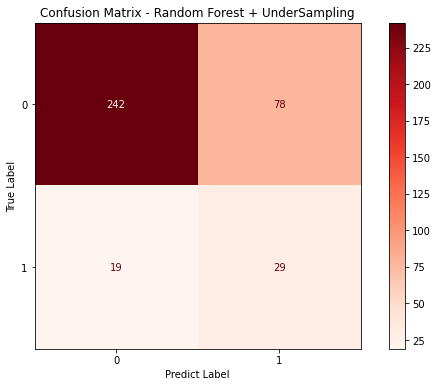

In [27]:
matrix_RF = plot_confusion_matrix(undersample_model_RF, undersample_atributos_test, undersample_target_test, cmap=plt.cm.Reds, values_format = '.5g')
matrix_RF.ax_.set_title('Confusion Matrix - Random Forest + UnderSampling', color = 'black')
plt.xlabel('Predict Label', color='black')
plt.ylabel('True Label', color='black')
plt.gcf().axes[1].tick_params(colors='black')
plt.gcf().axes[0].tick_params(colors='black')
plt.gcf().set_size_inches(10,6)
plt.show()

- *Gradient Boosting*

In [28]:
undersample_model_GB = ensemble.GradientBoostingClassifier(random_state=42, n_estimators=100)
undersample_model_GB.fit(downsampled_train_attribute, downsampled_train_target.ravel())
undersample_predict_GB = undersample_model_GB.predict(undersample_atributos_test)

In [30]:
print("Acurácia do modelo: {0:.2f}%".format(metrics.accuracy_score(undersample_target_test, undersample_predict_GB) * 100))
print()

print("Confusion Matrix")
print("")

print("{0}".format(metrics.confusion_matrix(undersample_target_test, undersample_predict_GB , labels = [1,0])))
print(" ")

print("Classification Report")
print("")

print(metrics.classification_report(undersample_target_test, undersample_predict_GB, labels = [1,0]))

Acurácia do modelo: 69.29%

Confusion Matrix

[[ 29  19]
 [ 94 226]]
 
Classification Report

              precision    recall  f1-score   support

           1       0.24      0.60      0.34        48
           0       0.92      0.71      0.80       320

    accuracy                           0.69       368
   macro avg       0.58      0.66      0.57       368
weighted avg       0.83      0.69      0.74       368



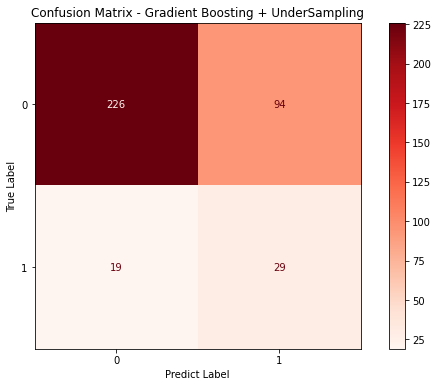

In [31]:
matrix_RF = plot_confusion_matrix(undersample_model_GB, undersample_atributos_test, undersample_target_test, cmap=plt.cm.Reds, values_format = '.5g')
matrix_RF.ax_.set_title('Confusion Matrix - Gradient Boosting + UnderSampling', color = 'black')
plt.xlabel('Predict Label', color='black')
plt.ylabel('True Label', color='black')
plt.gcf().axes[1].tick_params(colors='black')
plt.gcf().axes[0].tick_params(colors='black')
plt.gcf().set_size_inches(10,6)
plt.show()